In [339]:
import numpy as np
import scienceplots
from matplotlib import pyplot as plt
import matplotlib as mp
import pandas as pd
import os
import scipy as sp
import seaborn as sns
import json
import yaml
import functools
import itertools

In [340]:
prefix='sockperf-eval'
prefix='upload-res2'
prefix='bench-results'

In [341]:
res_dir = os.listdir(f'../{prefix}')[0]
res_dir = f"{prefix}/{res_dir}"

In [342]:
def import_pidstat(res_dir, batched=False, batches=[2,4,8,16,32], cc_levels=[4, 16, 32]):
    if not batched:
        names = ['cpu','client','run','timestamp','wait','used','core','command']
        pidstat = pd.read_csv(f"../{res_dir}/summary/server/cpu-pidstat.csv", names=names, skiprows=1)
        pidstat = pidstat[pidstat.used >= 0]
        tmp = pidstat.groupby(['cpu', 'client', 'core', 'timestamp', 'run']).sum(numeric_only=True).reset_index() 
        tmp = tmp.groupby(['cpu', 'client', 'core', 'run']).median(numeric_only=True).reset_index()
        tmp = tmp.groupby(['cpu', 'client', 'core']).median(numeric_only=True).reset_index()
        global_cpu = tmp.groupby(['cpu', 'client']).mean().reset_index()
        return global_cpu, tmp
    else:
        dfs = {}
        for batch, cc_level in itertools.product(batches, cc_levels):
            names = ['cpu','client','run','timestamp','wait','used','core','command']
            pidstat = pd.read_csv(
                f"../{res_dir}/summary/batch-{batch}/concurrency-{cc_level}/server/cpu-pidstat.csv",
                names=names, skiprows=1)
            pidstat = pidstat[pidstat.used >= 0]
            tmp = pidstat.groupby(['cpu', 'client', 'core', 'timestamp', 'run']).sum(numeric_only=True).reset_index() 
            tmp = tmp.groupby(['cpu', 'client', 'core', 'run']).median(numeric_only=True).reset_index()
            tmp = tmp.groupby(['cpu', 'client', 'core']).median(numeric_only=True).reset_index()
            global_cpu = tmp.groupby(['cpu', 'client']).median().reset_index()
            global_cpu['batch'] = batch
            global_cpu['concurrency'] = cc_level
            dfs[(batch, cc_level)] = global_cpu
        return dfs
            

def import_cpu(res_dir):
    cpu = pd.read_csv(f"../{res_dir}/summary/server/cpu-sar.csv")
    cpu = cpu[cpu.core != -1]
    tmp = cpu.groupby(['cpu', 'client', 'core', 'run']).max().reset_index()
    tmp = cpu.groupby(['cpu', 'client', 'core']).max().reset_index()
    tmp['used'] = 100 - tmp['idle']
    global_cpu = tmp.groupby(['cpu', 'client']).median().reset_index()
    return global_cpu, tmp

def import_latency(res_dir, batched=False, batches=[2,4,8,16,32], cc_levels=[4, 16, 32]):
    if not batched:
        latency = pd.read_csv(f"../{res_dir}/summary/clients/sockperf-1.csv")
        tails = ['99th', '99.9th', '99.99th', '99.999th',]
        cols = ['min', 'median', 'max'] + tails
        latency = latency.groupby(['cpu', 'client', 'run']).max().reset_index()
        latency = latency.groupby(['cpu', 'client']).max().reset_index()
        latency[cols] /= 1000
        return latency
    else:
        dfs = {}
        for batch, cc_level in itertools.product(batches, cc_levels):
            latency = pd.read_csv(f"../{res_dir}/summary/batch-{batch}/concurrency-{cc_level}/clients/sockperf-1.csv")
            tails = ['99th', '99.9th', '99.99th', '99.999th',]
            cols = ['median', 'max'] + tails
            latency = latency.groupby(['cpu', 'client', 'run']).max().reset_index()
            latency = latency.groupby(['cpu', 'client']).max().reset_index()
#             print(batch, cc_level)
            latency[cols] /= 1000
            latency['batch'] = batch
            latency['concurrency'] = cc_level
            dfs[(batch, cc_level)] = latency
        return dfs
            

def import_throughput(res_dir, batched=False, batches=[2,4,8,16,32], cc_levels=[4, 16, 32]):
    if not batched:
        net = pd.read_csv(f"../{res_dir}/summary/server/throughput-sar.csv")
        net = net[net.iface == 'wg']
        net = net.groupby(['cpu', 'client', 'run']).median(numeric_only=True).reset_index()
        net = net.groupby(['cpu', 'client',]).max(numeric_only=True).reset_index()
        net['rxkB/s'] = net['rxkB/s'] * 8 / 1e6
        net['txkB/s'] = net['txkB/s'] * 8 / 1e6
        return net
    else:
        dfs = {}
        for batch, cc_level in itertools.product(batches, cc_levels):
            net = pd.read_csv(f"../{res_dir}/summary/batch-{batch}/concurrency-{cc_level}/server/throughput-sar.csv")
            net = net[net.iface == 'wg']
            net = net.groupby(['cpu', 'client', 'run']).max(numeric_only=True).reset_index()
            net = net.groupby(['cpu', 'client',]).max(numeric_only=True).reset_index()
            net['rxkB/s'] = net['rxkB/s'] * 8 / 1e6
            net['txkB/s'] = net['txkB/s'] * 8 / 1e6
            net['batch'] = batch
            net['concurrency'] = cc_level
            dfs[(batch, cc_level)] = net
        return dfs

def plot_all(res_dirs, importer, kind='bar', y='used', 
             variants=[0,1], variant_names=['VANILLA', 'CRYPTONCE'], correct=[], 
             ylabel='CPU Usage (in \%)', ylim=None, figsize=(4, 3), ncols=1,
             space=.1, annotate='improvement', annotate_baseline='VANILLA', annotate_variant='CRYPTONCE', 
             fontsize=8, savefig=None, columnspacing=1):
#     vanilla = importer(res_dirs[0][0])
#     cryptonce = importer(res_dirs[1][0])
    baseline = importer(res_dirs[variants[0]][0])
    
    dfs = [importer(res_dirs[i][0]) for i in variants]

    for df_idx, key, val in correct:
        dfs[df_idx].loc[key, y] = val
    
    df = pd.DataFrame()
    df['client'] = dfs[0]['client']
    for df_, name in zip(dfs, variant_names):
        df[name] = df_[y]
    
    df['diff'] = df[annotate_baseline] - df[annotate_variant]
    df['improvement'] = df['diff'] * 100 / df[annotate_baseline]

    with plt.style.context(['science', 'ieee']):
        if kind == 'bar':
            ax = df.plot.bar(x='client', y=variant_names, color=['black', 'red', 'blue', 'green'],
                   grid=True, ylabel=ylabel, ylim=ylim, figsize=figsize, xlabel='Clients')
            plt.xticks(rotation=0)
            
            if annotate is not None:
                for k, i in enumerate(df.index):
                    suffix = "\%" if annotate == "improvement" else ""
                    max_height = df.loc[i, annotate_baseline]  # Position at the higher bar
                    ax.text(k, max_height + space, f'{df.loc[i, annotate]:.2f}{suffix}', 
                            ha='center', fontsize=fontsize)
            
        elif kind == 'line':
            ax = baseline.plot(
                x='client', y=y, grid=True, color='black', marker='x',
                label=variant_names[0], xlabel='Clients', ylabel=ylabel,
            )
            for df_, name in zip(dfs[1:], variant_names[1:]):
                ax = df_.plot(ax=ax, marker='o', figsize=figsize,
                    x='client', y=y, grid=True, color='red',
                    label=name, xlabel='Clients', ylabel=ylabel, ylim=ylim
                )
        plt.legend(loc='upper left', ncol=ncols, columnspacing=columnspacing)
        if savefig is not None:
            plt.savefig(savefig, dpi=400)
        plt.show()
    return df

In [343]:
batches = [2, 4, 8, 16, 32]
cc_levels = [4, 16, 32]

def reslv_res_name(res_dir):
    batch = False
    filename = f"../{res_dir}/EXPERIMENT_DATA/CURRENT_EXP"
    if "batch" in filename:
        batch = True
    
    with open(filename) as file:
        test_config = file.read().strip()
    
#     yaml_file = f"../{res_dir}/EXPERIMENT_DATA/{test_config}.yaml"
#     with open(yaml_file) as file:
#         content = yaml.load(file, yaml.FullLoader)
#         flow = content['all']['vars']['bandwidth']
    if test_config != 'default':
        variant = '-'.join(test_config.split('-')[1:])
     
    return test_config, variant

In [344]:
os.listdir(f"../{prefix}")

['results-d1fc748b',
 'results-a59a8715',
 'results-53da84af',
 'results-076401b1']

In [345]:
res_dirs = [(f"{prefix}/{e}", *reslv_res_name(f"{prefix}/{e}")) 
            for e in os.listdir(f"../{prefix}") if e.startswith("results-")]

In [346]:
list(enumerate(res_dirs))

[(0,
  ('bench-results/results-d1fc748b',
   'benchmark-wireguard-multi-queue',
   'wireguard-multi-queue')),
 (1, ('bench-results/results-a59a8715', 'benchmark-vanilla', 'vanilla')),
 (2,
  ('bench-results/results-53da84af',
   'benchmark-wireguard-batch',
   'wireguard-batch')),
 (3,
  ('bench-results/results-076401b1',
   'benchmark-wireguard-multi-queue',
   'wireguard-multi-queue'))]

In [347]:
# 1. find yes and put it at start
# 2. find no and put it at second

def find_index(res_dirs, val):
    for k, res in enumerate(res_dirs):
        if res[4] == val:
            return k

def print_tab(tab):
    for i in tab:
        print(i)

In [557]:
prefix='bench-results'
try:
    os.makedirs(f"../graphs/{prefix}")
except:
    pass
res_dirs = [(f"{prefix}/{e}", *reslv_res_name(f"{prefix}/{e}")) 
            for e in os.listdir(f"../{prefix}") if e.startswith("results-")]
# index = find_index(res_dirs, 'yes')
# yes = res_dirs.pop(index)
# res_dirs.insert(0, yes)
# print_tab(enumerate(res_dirs))

res_dirs_ = {}
for p_, _, name in res_dirs:
    res_dirs_[name] = p_


In [558]:
res_dirs_

{'wireguard-no-queue': 'bench-results/results-26a44206',
 'wireguard-multi-queue': 'bench-results/results-d1fc748b',
 'vanilla-target-on-server': 'bench-results/results-89e97a57',
 'vanilla': 'bench-results/results-a59a8715',
 'wireguard-batch': 'bench-results/results-53da84af',
 'wireguard-batch-multi-queue': 'bench-results/results-e1462767'}

In [559]:
def pidstat_importer(res_dir):
    return import_pidstat(res_dir)[0]

def cpu_importer(res_dir):
    return import_cpu(res_dir)[0]

In [560]:
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)

In [561]:
plt.style.use(['science', 'ieee'])

In [565]:
out = {}
variant = 'vanilla-target-on-server'
# df_net = pd.read_csv(f"../{res_dirs_[variant]}/summary/throughput.csv").dropna()
# df = df_net[df_net.clients == 100]
# out['Throughput'] = df.throughput.iloc[0]

# df_latency = pd.read_csv(f"../{res_dirs_[variant]}/summary/latency.csv").dropna()
# df = df_latency[df_latency.clients == 100]
# out['Latency'] = df.p99.iloc[0]

df_cpu = import_pidstat(res_dirs_[variant])[0].rename(columns={'client': 'clients'})
df = df_cpu[df_cpu.clients == 100]
out['cpu'] = df.used.iloc[0]

out_vanilla = out
out_vanilla

{'cpu': 28.90736842105263}

# Vanilla

In [562]:
out = {}
variant = 'vanilla'
df_net = pd.read_csv(f"../{res_dirs_[variant]}/summary/throughput.csv").dropna()
df = df_net[df_net.clients == 100]
out['Throughput'] = df.throughput.iloc[0]

df_latency = pd.read_csv(f"../{res_dirs_[variant]}/summary/latency.csv").dropna()
df = df_latency[df_latency.clients == 100]
out['Latency'] = df.p99.iloc[0]

df_cpu = import_pidstat(res_dirs_[variant])[0].rename(columns={'client': 'clients'})
df = df_cpu[df_cpu.clients == 100]
out['cpu'] = df.used.iloc[0]

out_vanilla = out
out_vanilla

{'Throughput': 7547.7271, 'Latency': 489026.0, 'cpu': 30.028333333333332}

# Multi-Queue

In [454]:
out = {}
variant = 'wireguard-multi-queue'
df_net = pd.read_csv(f"../{res_dirs_[variant]}/summary/throughput.csv").dropna()
df = df_net[df_net.clients == 100]
out['Throughput'] = df.throughput.iloc[0]

df_latency = pd.read_csv(f"../{res_dirs_[variant]}/summary/latency.csv").dropna()
df = df_latency[df_latency.clients == 100]
out['Latency'] = df.p99.iloc[0]

df_cpu = import_pidstat(res_dirs_[variant])[0].rename(columns={'client': 'clients'})
df = df_cpu[df_cpu.clients == 100]
out['cpu'] = df.used.iloc[0]

out_mq = out
out_mq

{'Throughput': 4804.8785, 'Latency': 352381, 'cpu': 26.833333333333332}

# Batch Multi Queue

In [455]:
out = {}
variant = 'wireguard-batch-multi-queue'
df_net = pd.read_csv(f"../{res_dirs_[variant]}/summary/throughput.csv").dropna()
df = df_net[df_net.clients == 100]
out['Throughput'] = df.throughput.iloc[0]

df_latency = pd.read_csv(f"../{res_dirs_[variant]}/summary/latency.csv").dropna()
df = df_latency[df_latency.clients == 100]
out['Latency'] = df.p99.iloc[0]

df_cpu = import_pidstat(res_dirs_[variant])[0].rename(columns={'client': 'clients'})
df = df_cpu[df_cpu.clients == 100]
out['cpu'] = df.used.iloc[0]

out_batch_mq = out
out_batch_mq

{'Throughput': 7550.8384, 'Latency': 474577.102, 'cpu': 30.442222222222224}

# No Queue

In [456]:
out = {}
variant = 'wireguard-no-queue'
df_net = pd.read_csv(f"../{res_dirs_[variant]}/summary/throughput.csv").dropna()
df = df_net[df_net.clients == 100]
out['Throughput'] = df.throughput.iloc[0]

df_latency = pd.read_csv(f"../{res_dirs_[variant]}/summary/latency.csv").dropna()
df = df_latency[df_latency.clients == 100]
out['Latency'] = df.p99.iloc[0]

df_cpu = import_pidstat(res_dirs_[variant])[0].rename(columns={'client': 'clients'})
df = df_cpu[df_cpu.clients == 100]
out['cpu'] = df.used.iloc[0]

out_no_queue = out
out_no_queue

{'Throughput': 14304.975, 'Latency': 2174.0, 'cpu': 37.18222222222222}

In [467]:
data = {
    'vanilla': out_vanilla,
    'multi-queue': out_mq,
    'batch-multi-queue': out_batch_mq,
    'no-queue': out_no_queue,
}
df = pd.DataFrame.from_dict(data, orient='index')
df['Latency'] /= 1000
df['Throughput'] /= 1024
df['gbps_per_cpu'] = df['Throughput'] / df['cpu']
df

,Throughput,Latency,cpu,gbps_per_cpu
vanilla,7.370827,489.026000,30.028333,0.245462
multi-queue,4.692264,352.381000,26.833333,0.174867
batch-multi-queue,7.373866,474.577102,30.442222,0.242225
no-queue,13.969702,2.174000,37.182222,0.375709


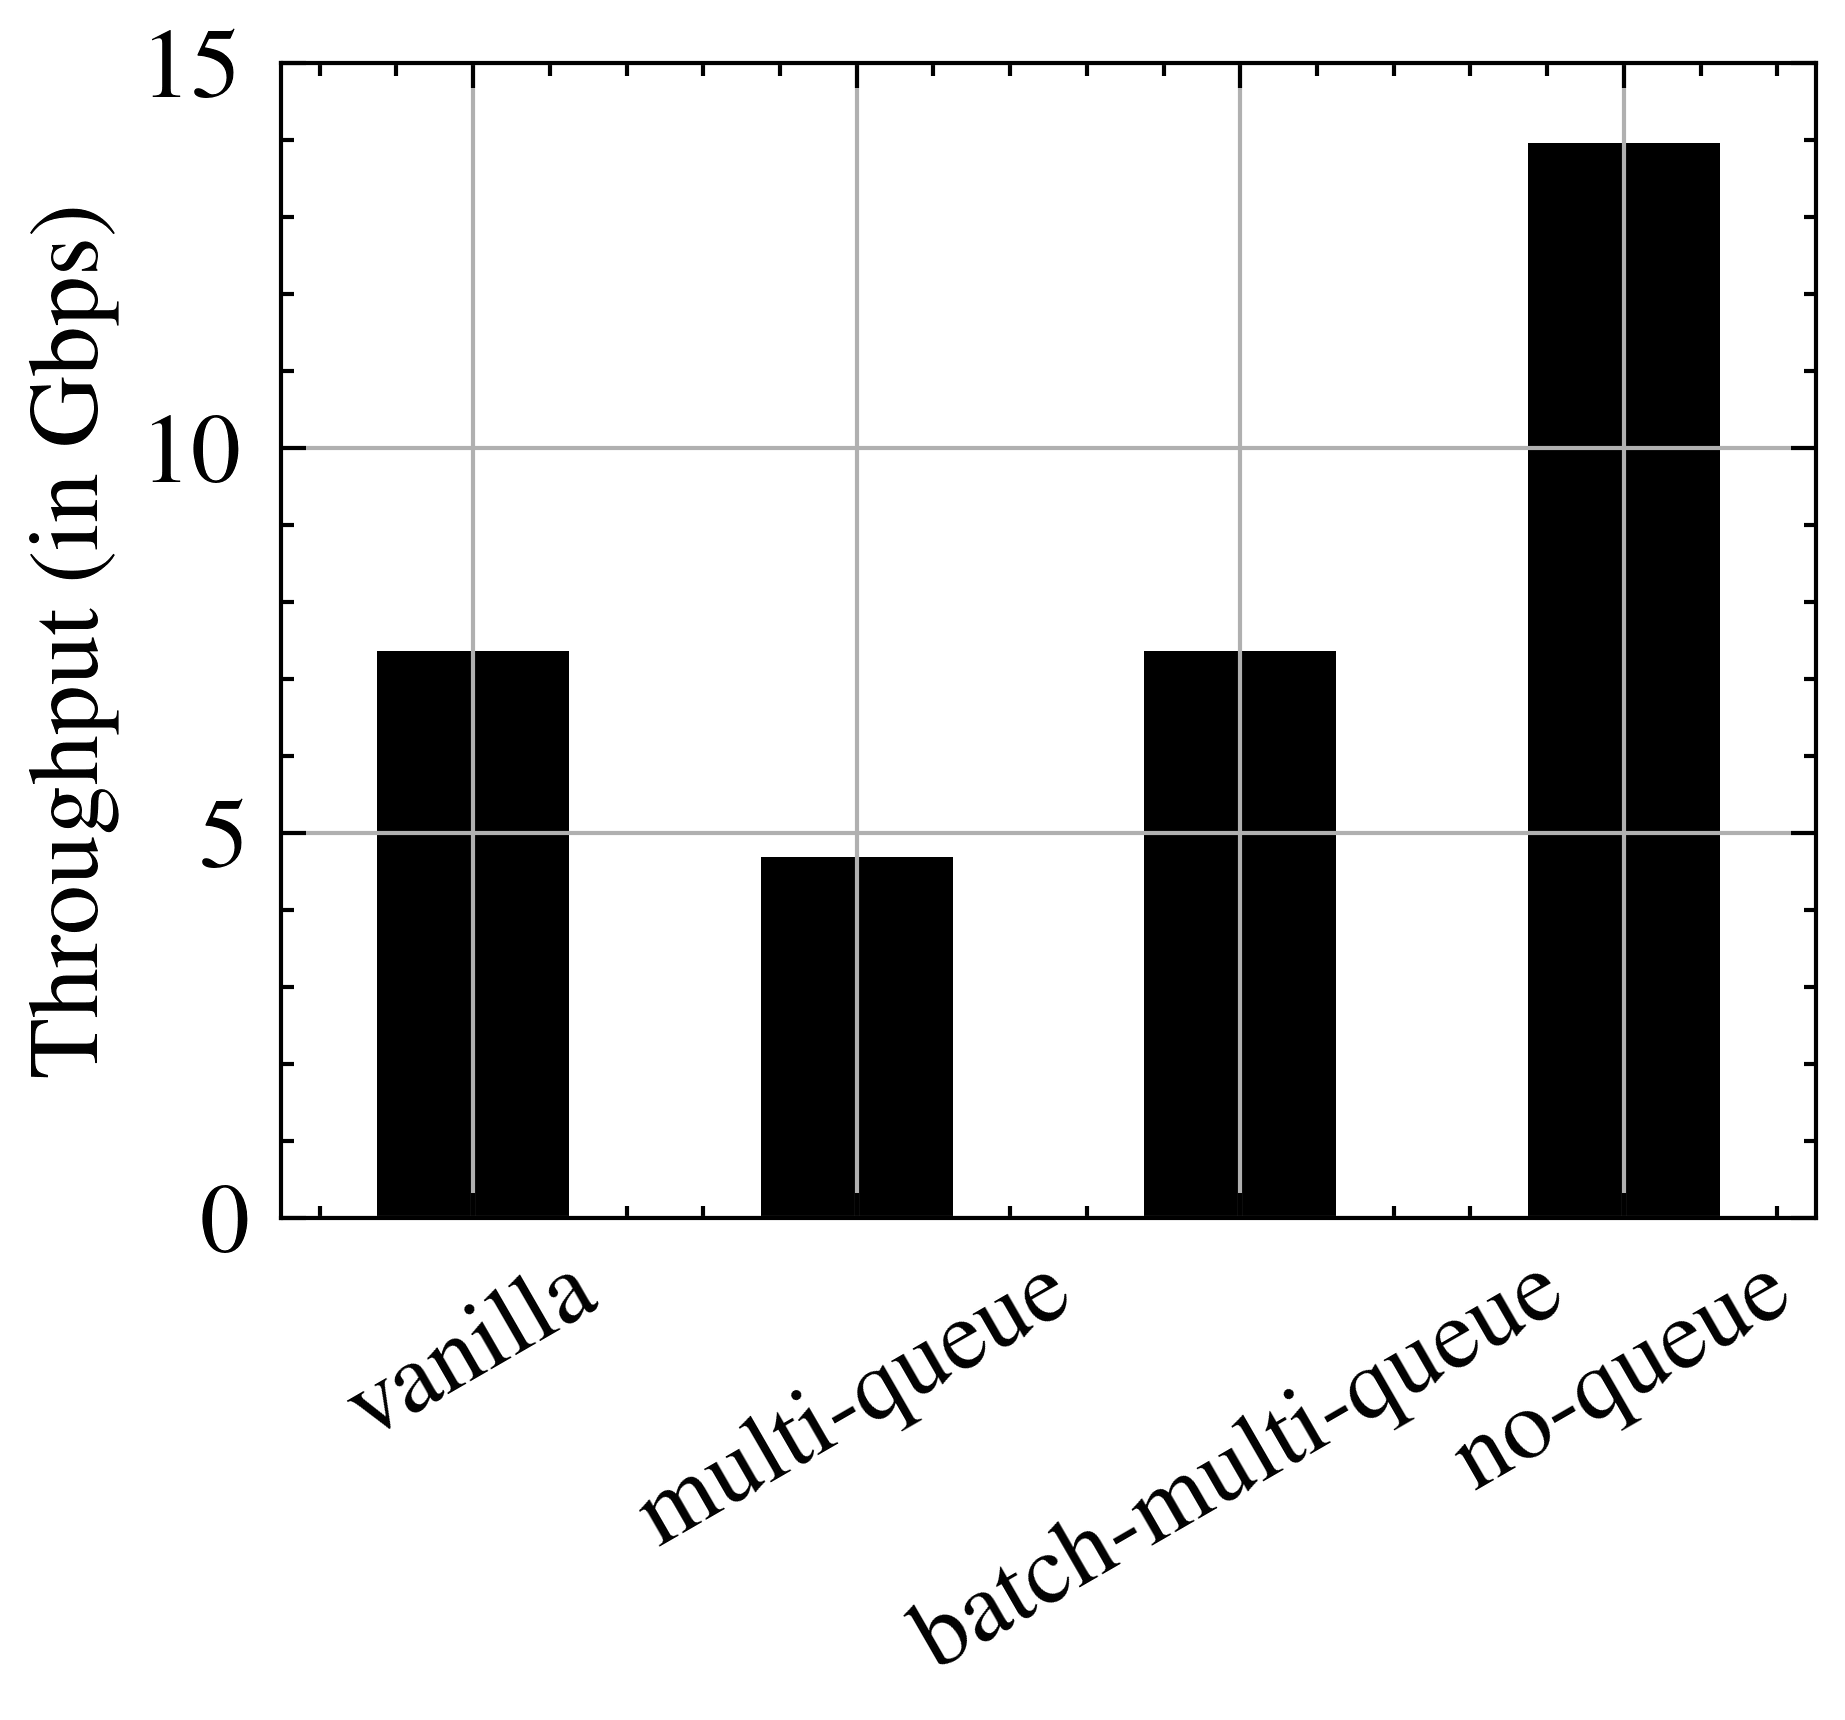

In [468]:
df['Throughput'].plot.bar(
    grid=True,
    ylabel="Throughput (in Gbps)",
    ylim=[0, 15]
)
plt.xticks(rotation=30)
plt.show()

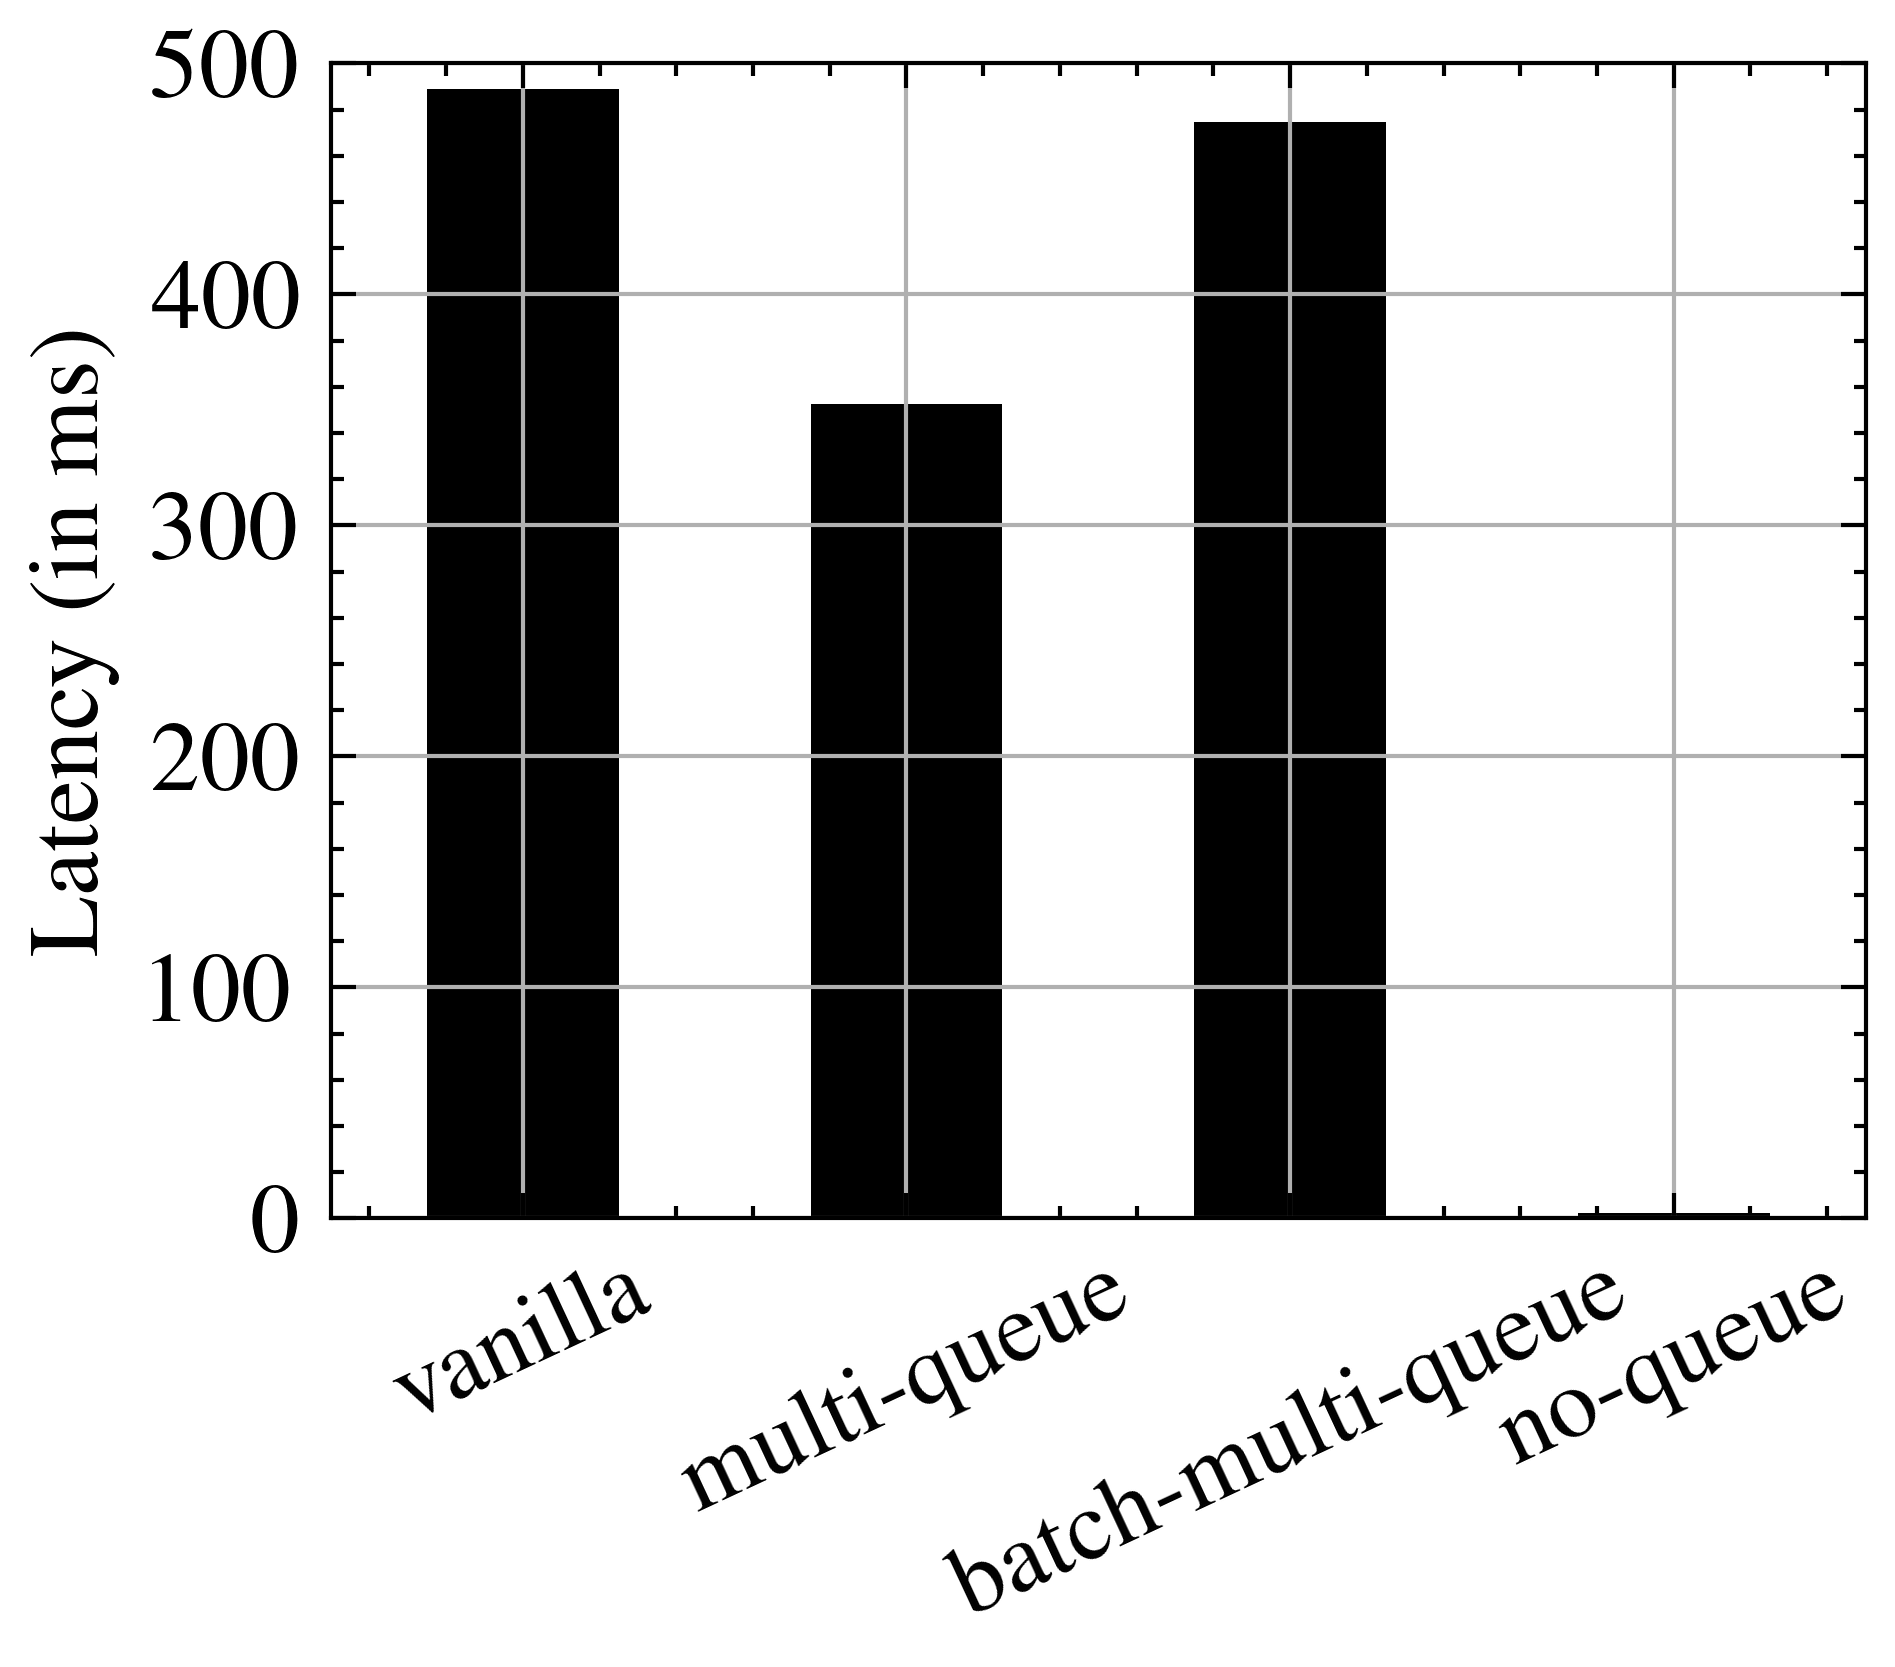

In [469]:
df['Latency'].plot.bar(
    grid=True,
    ylabel="Latency (in ms)",
    ylim=[0, 500],
)
plt.xticks(rotation=25)
plt.show()

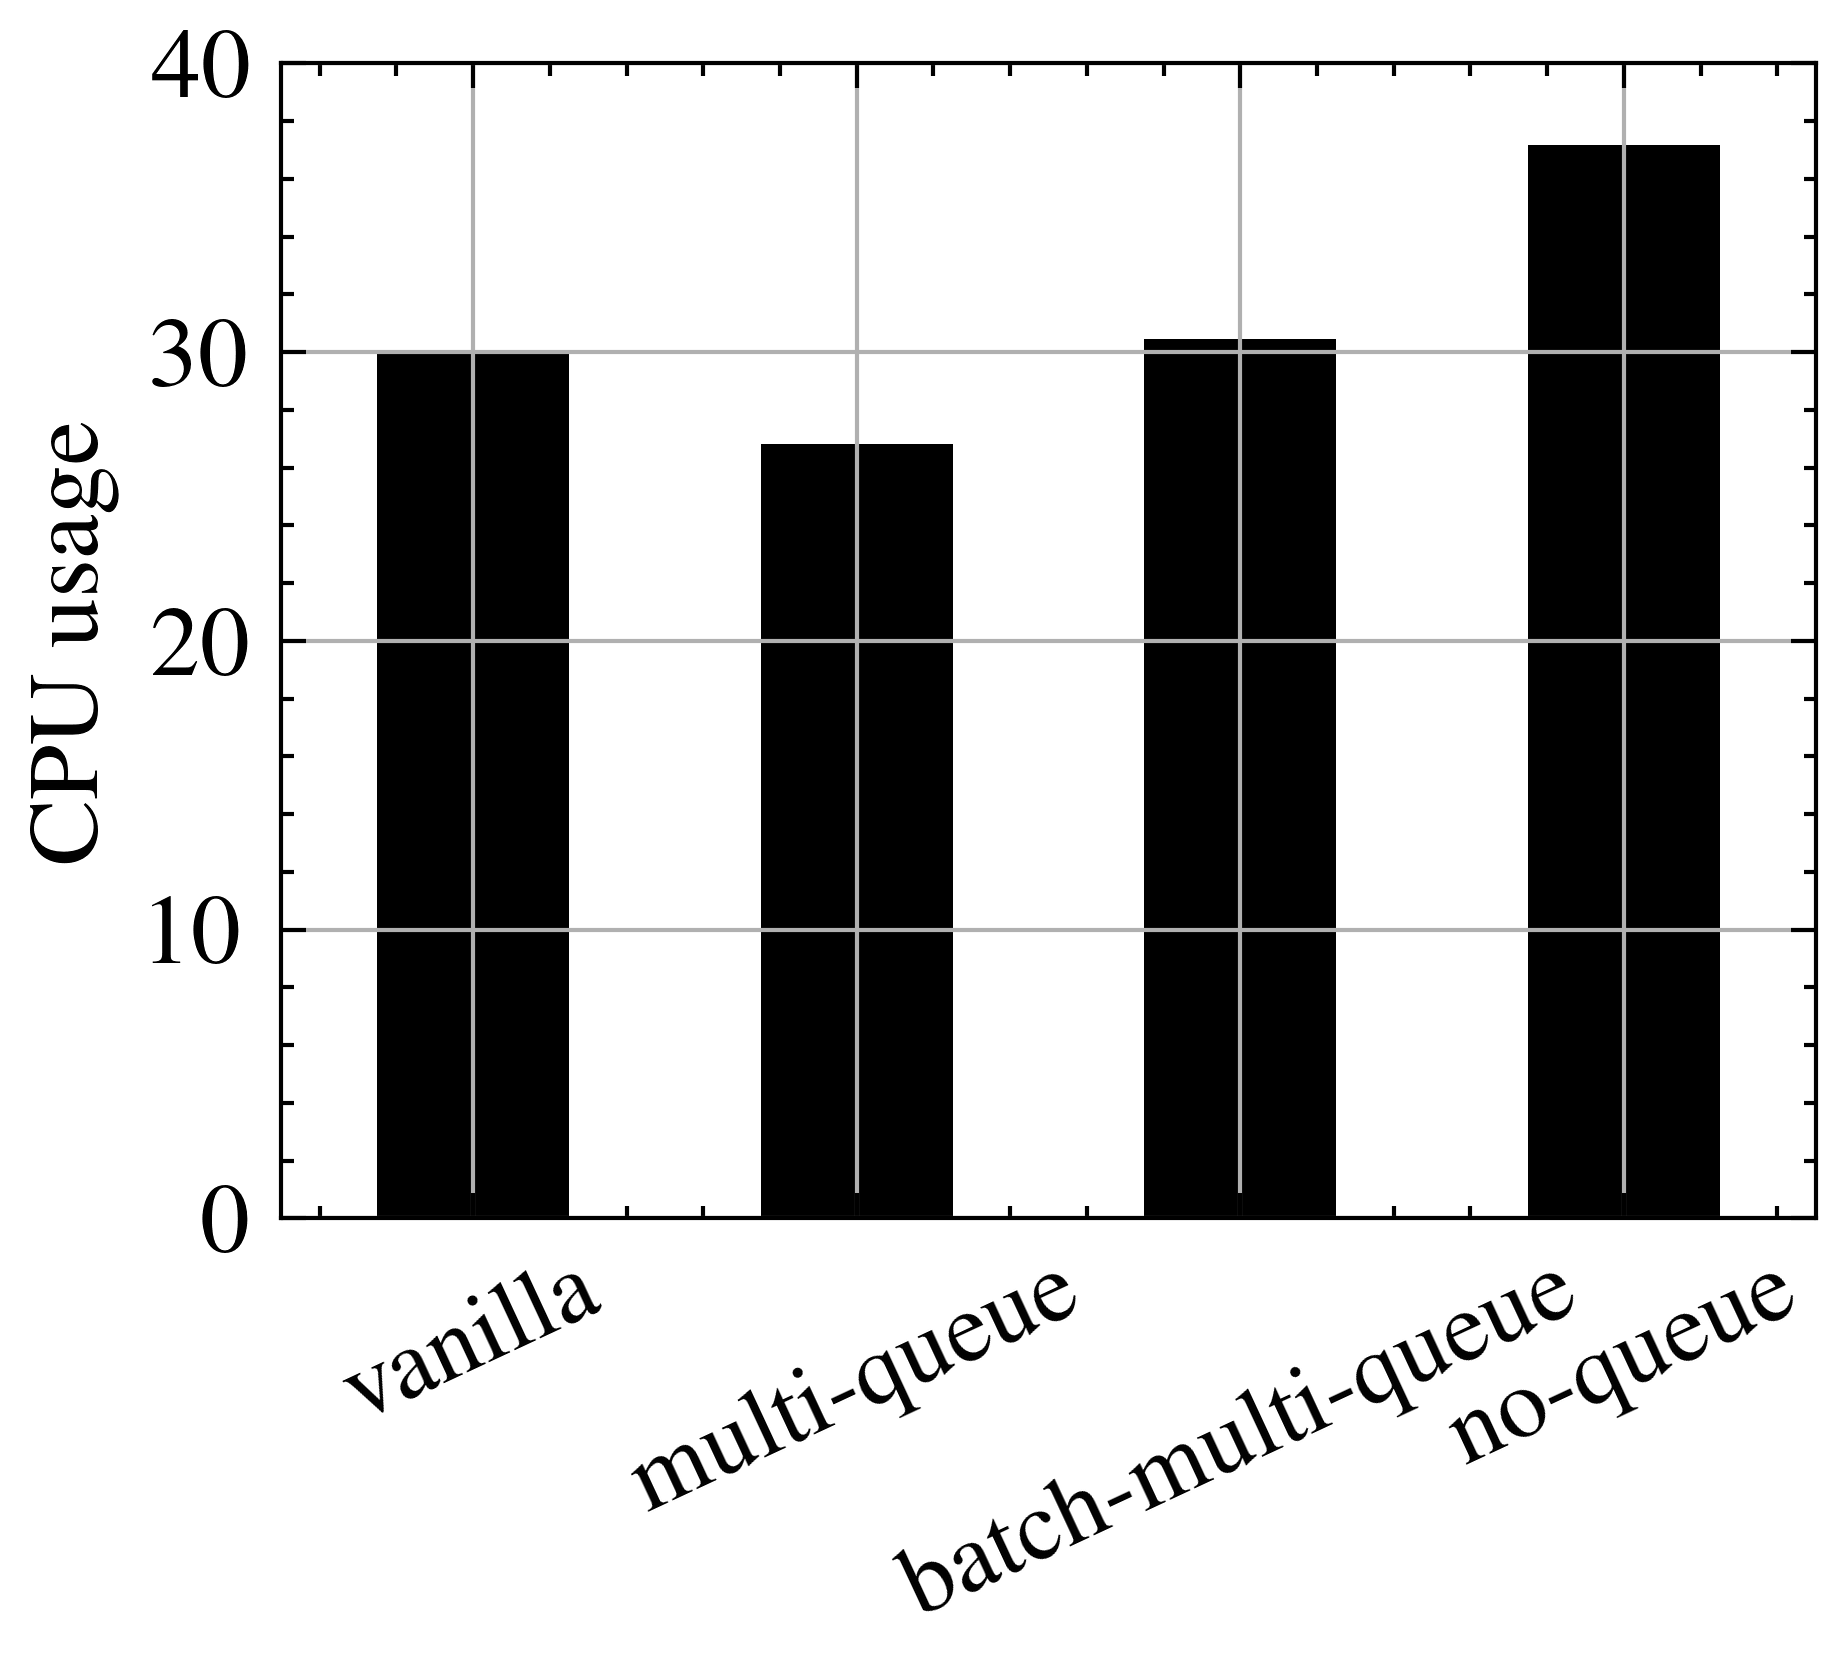

In [470]:
df['cpu'].plot.bar(
    grid=True,
    ylabel="CPU usage",
    ylim=[0, 40]
)
plt.xticks(rotation=25)
plt.show()

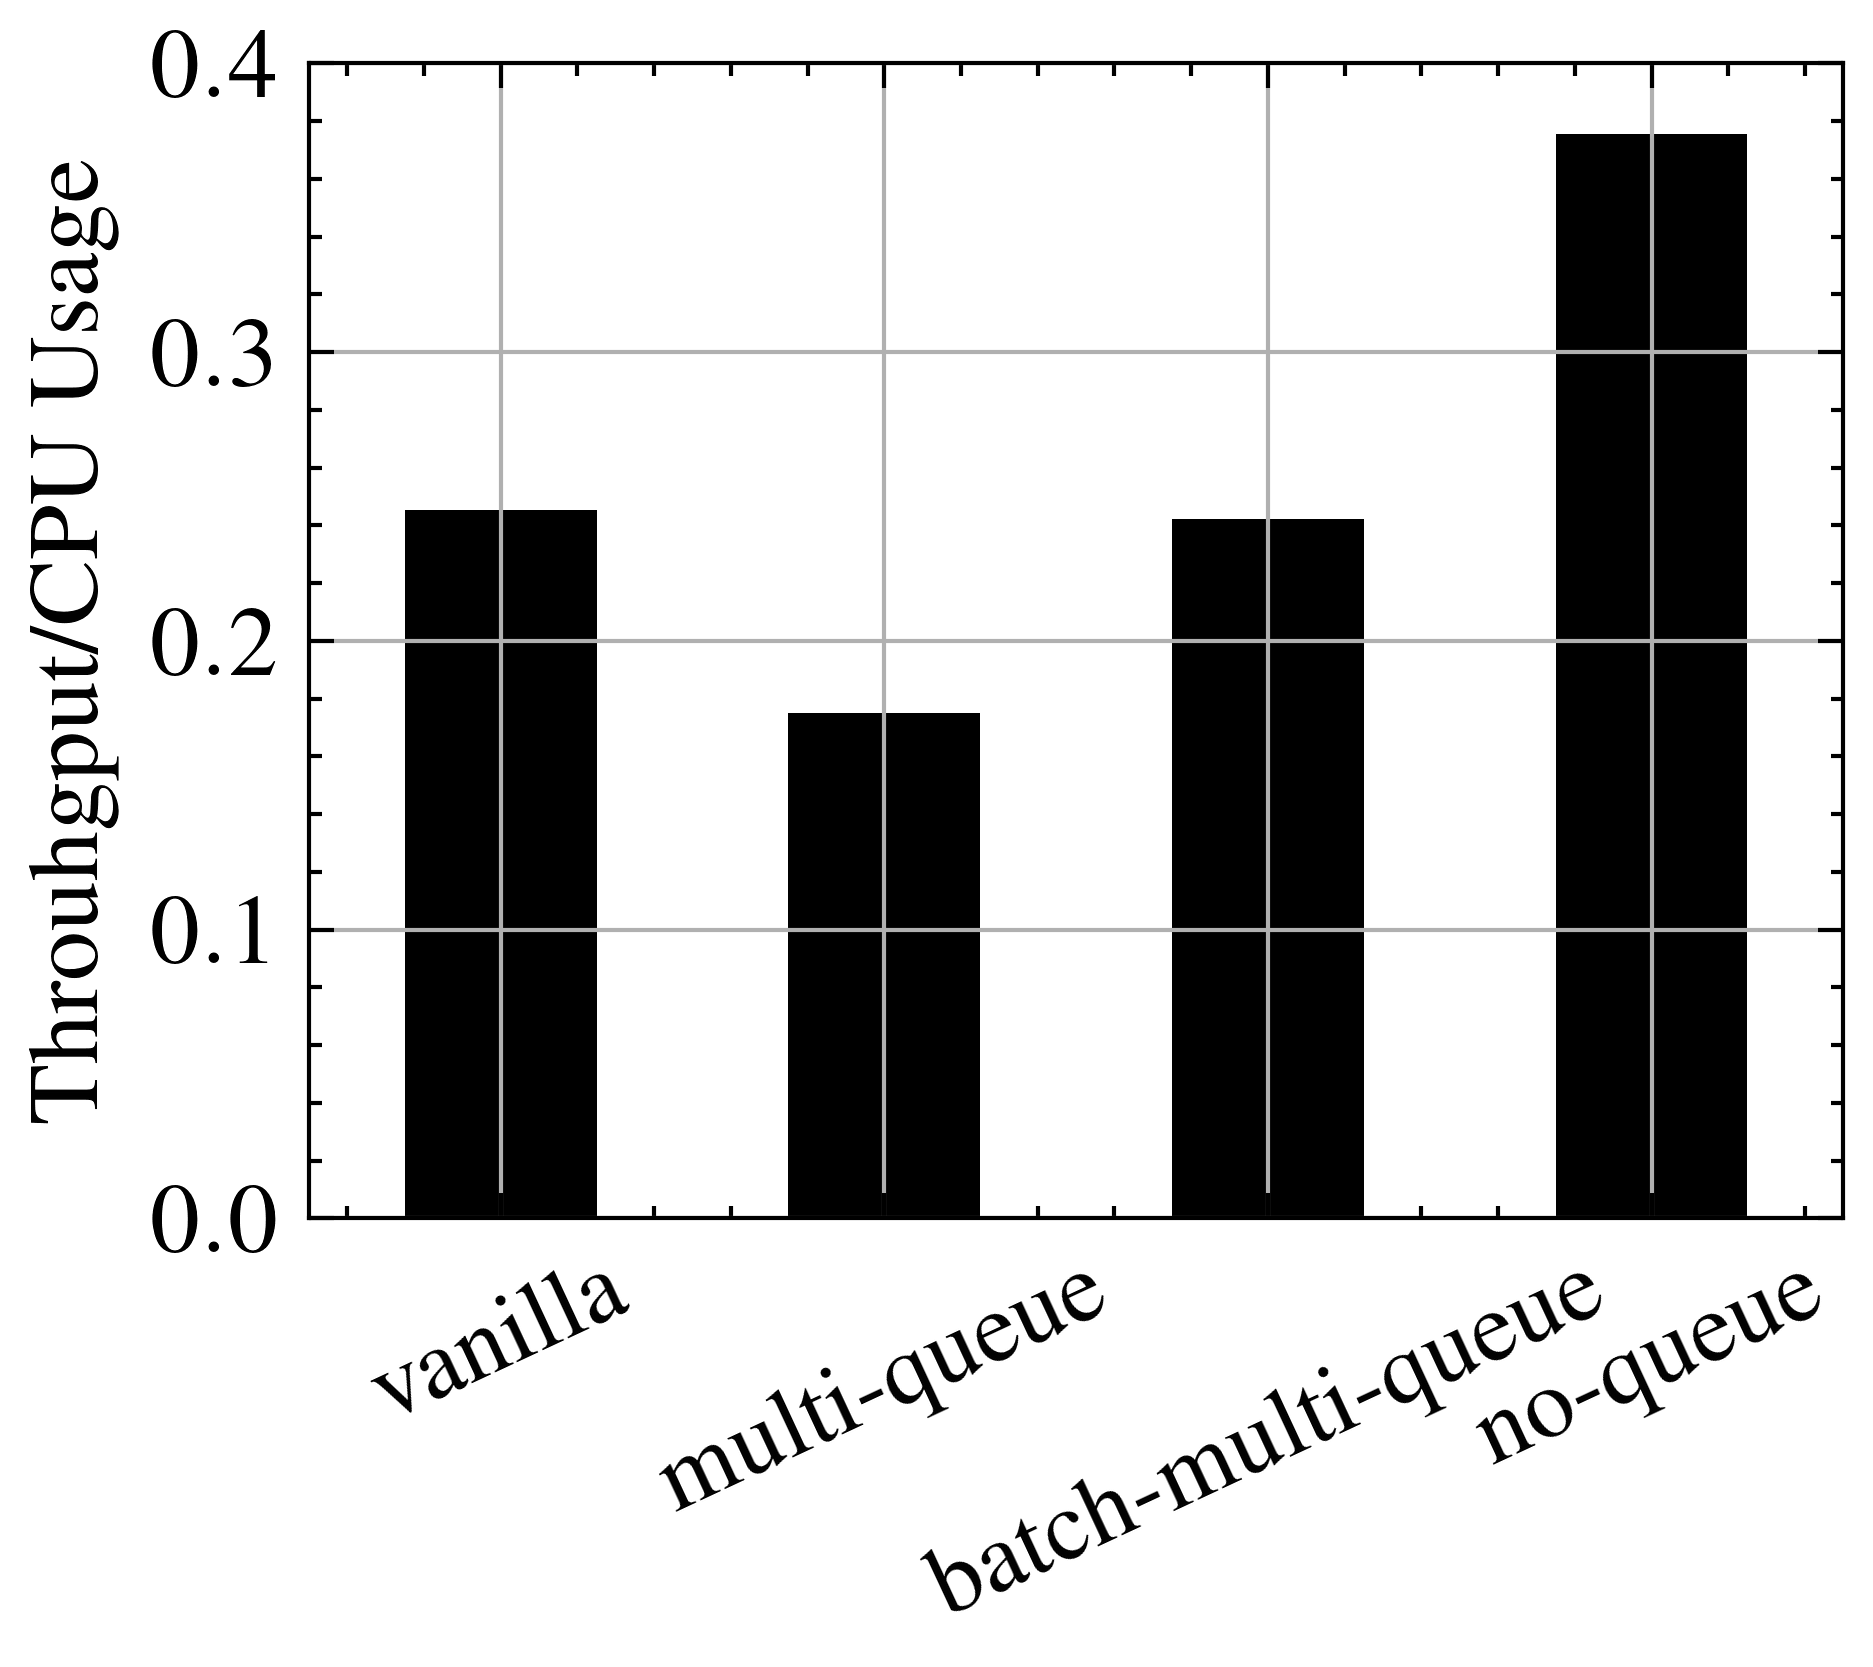

In [556]:
df['gbps_per_cpu'].plot.bar(
    grid=True,
    ylabel=" Throuhgput/CPU Usage",
    ylim=[0, 0.4]
)
plt.xticks(rotation=25)
plt.show()

In [545]:
metric = 'throughput'
ylabel = 'Throughput (in Gbps)'

def plot_batch(df_net, metric, ylabel, normalize=False, normal_value=None, ylim=None, text_offset=2.5, text_spacing=.2):
    df = df_net[df_net.clients == 100].pivot(index='batch', columns='concurrency', values=metric)
    if normalize:
        df = df / normal_value
    ax = df.plot.bar(
        figsize=(4, 3),
        grid=True, ylabel=ylabel,
        ylim=ylim,
    )
    if normalize:
        ax.axhline(y=1, color='black', linestyle='--', label='vanilla')
    if not normalize and normal_value is not None:
        ax.axhline(y=normal_value, color='black', linestyle='--', label='vanilla')
        ax.annotate(f'VANILLA', 
                    xy=(2, normal_value), 
                    xytext=(text_offset, normal_value+text_spacing), fontsize=12,
#                     textcoords='offset point'
        )
    plt.xticks(rotation=0)
#     plt.legend(loc='upper right', ncol=1)
    plt.show()
    return df

# Batch

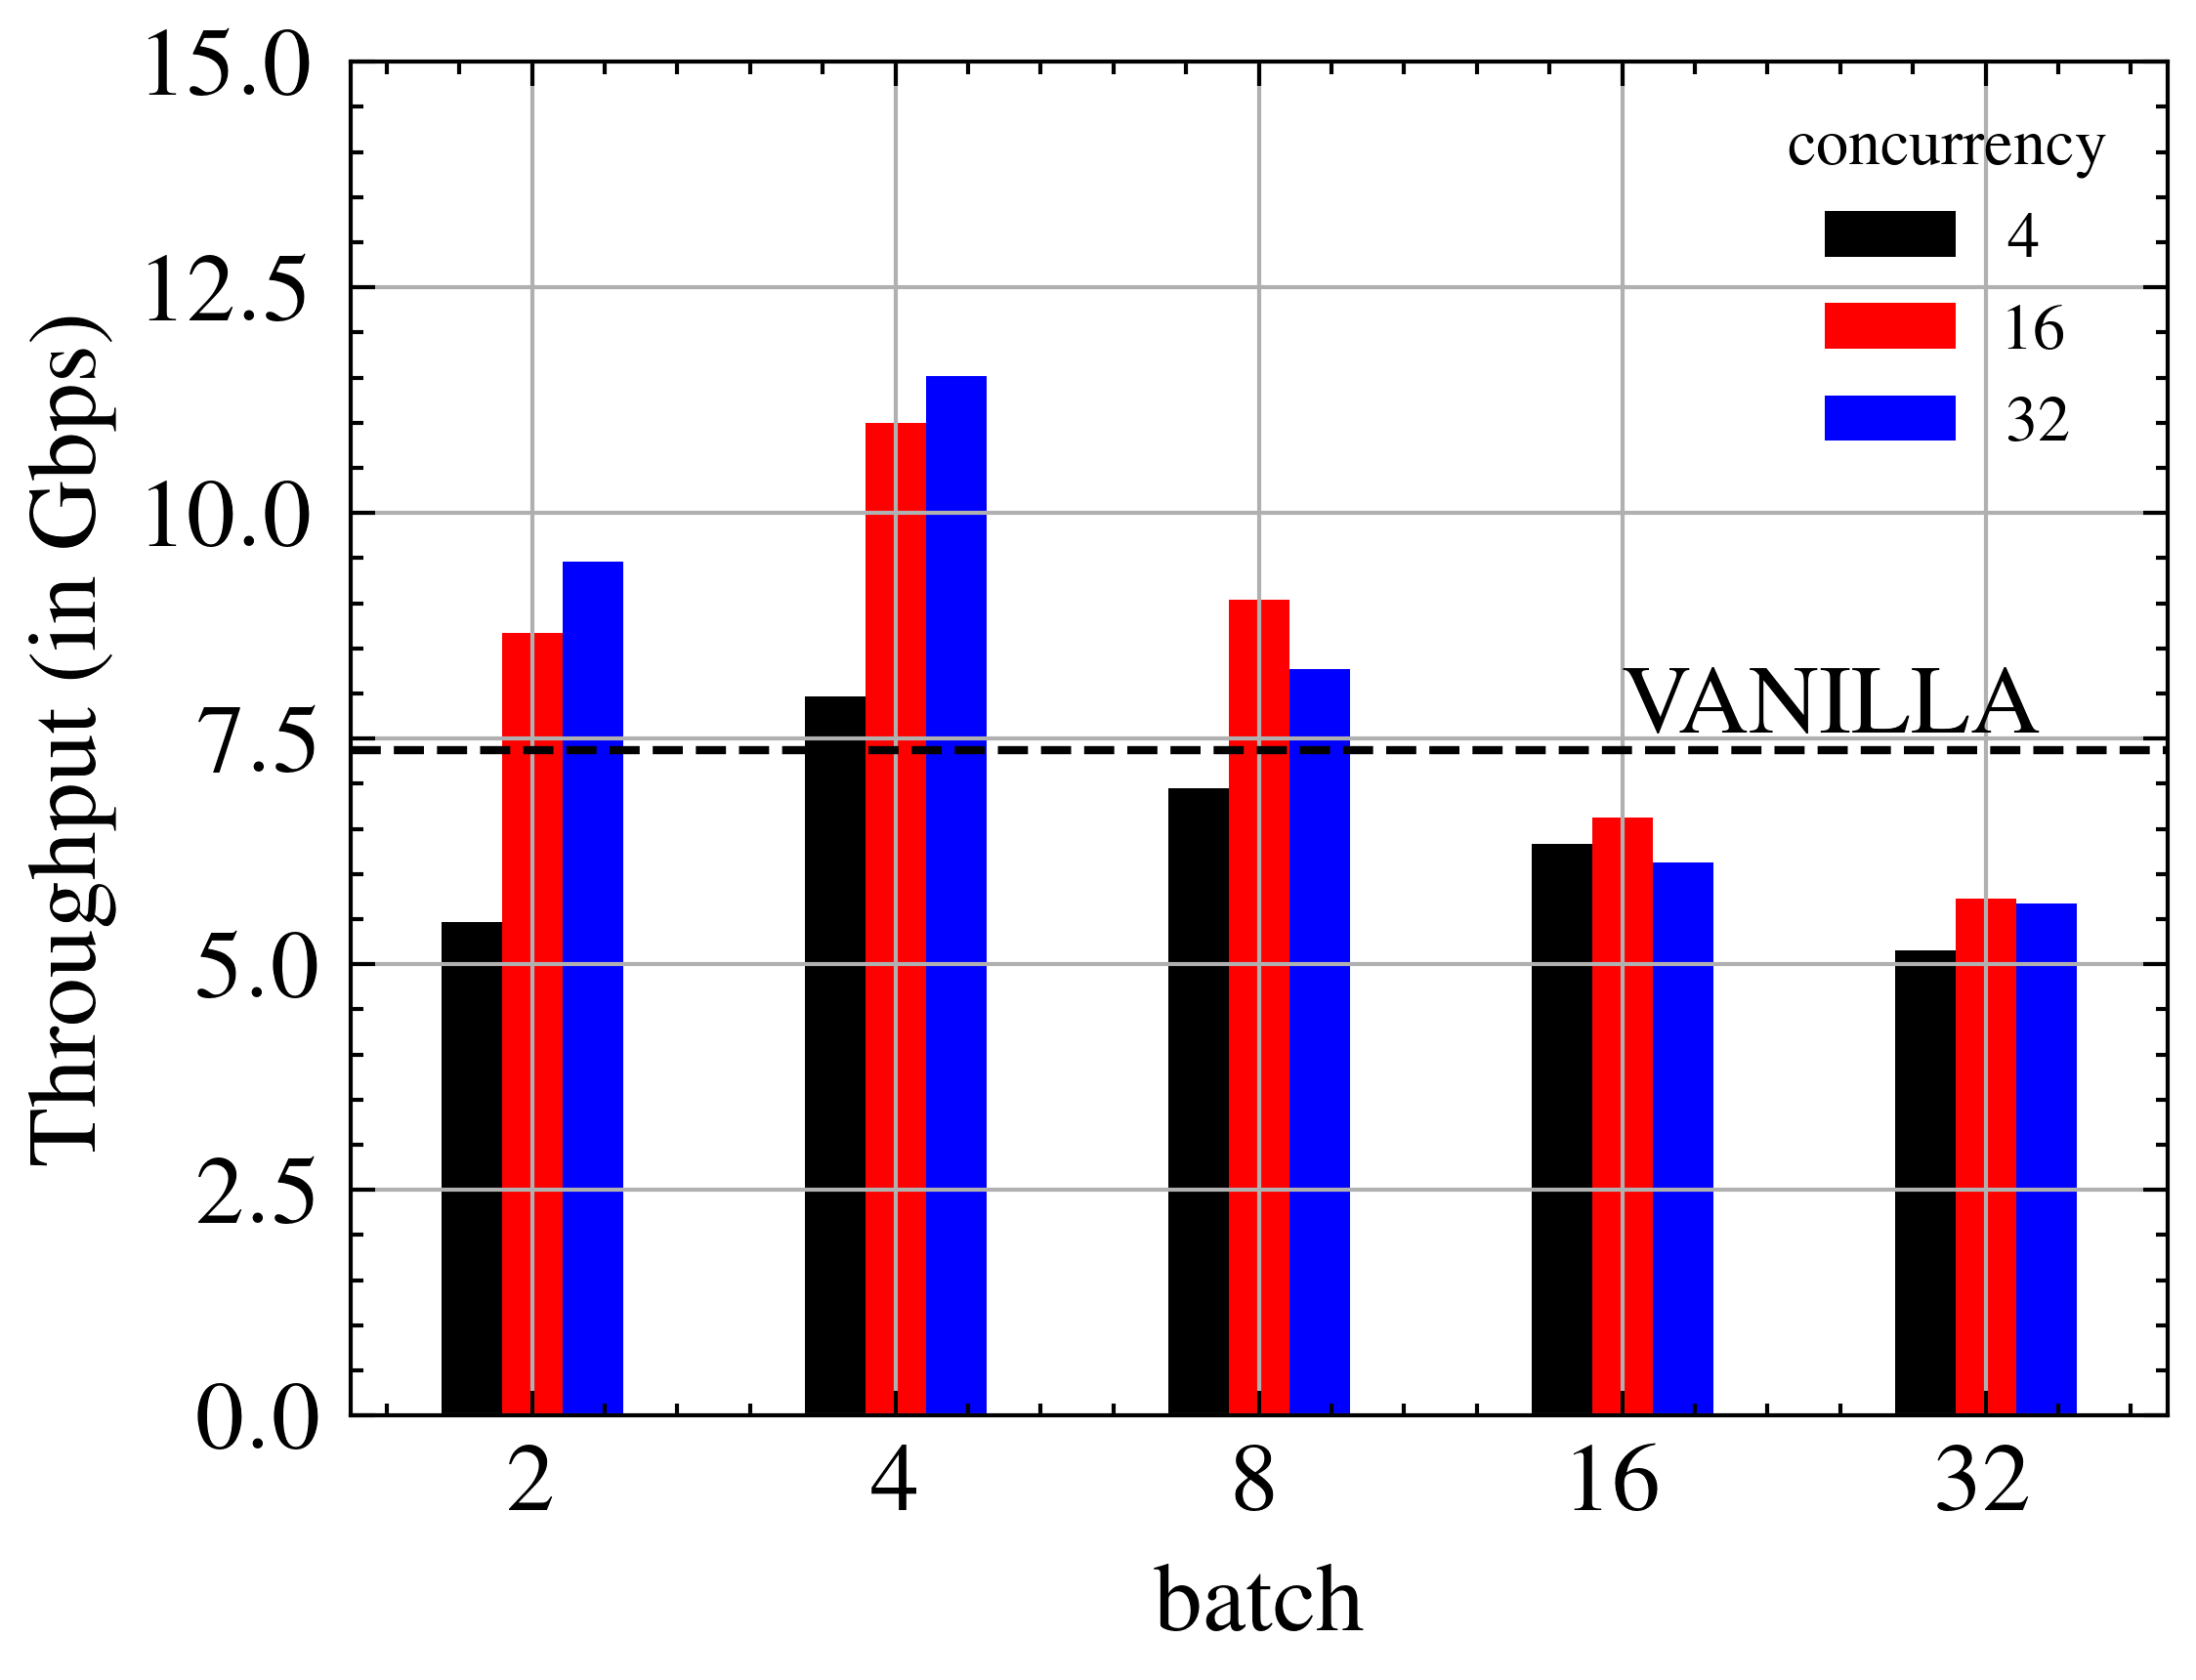

concurrency,4,16,32
batch,,,
2,5.470443,8.674975,9.459805
4,7.973217,10.999201,11.523485
8,6.952103,9.035979,8.276665
16,6.329187,6.627889,6.128967
32,5.158927,5.731516,5.668730


In [546]:
variant = 'wireguard-batch'
df_net = pd.read_csv(f"../{res_dirs_[variant]}/summary/throughput.csv").dropna()
df_net['throughput'] /= 1024
plot_batch(df_net, 'throughput', 'Throughput (in Gbps)', 
           normal_value=out_vanilla['Throughput']/1024, 
          ylim=[0, 15], text_offset=3)

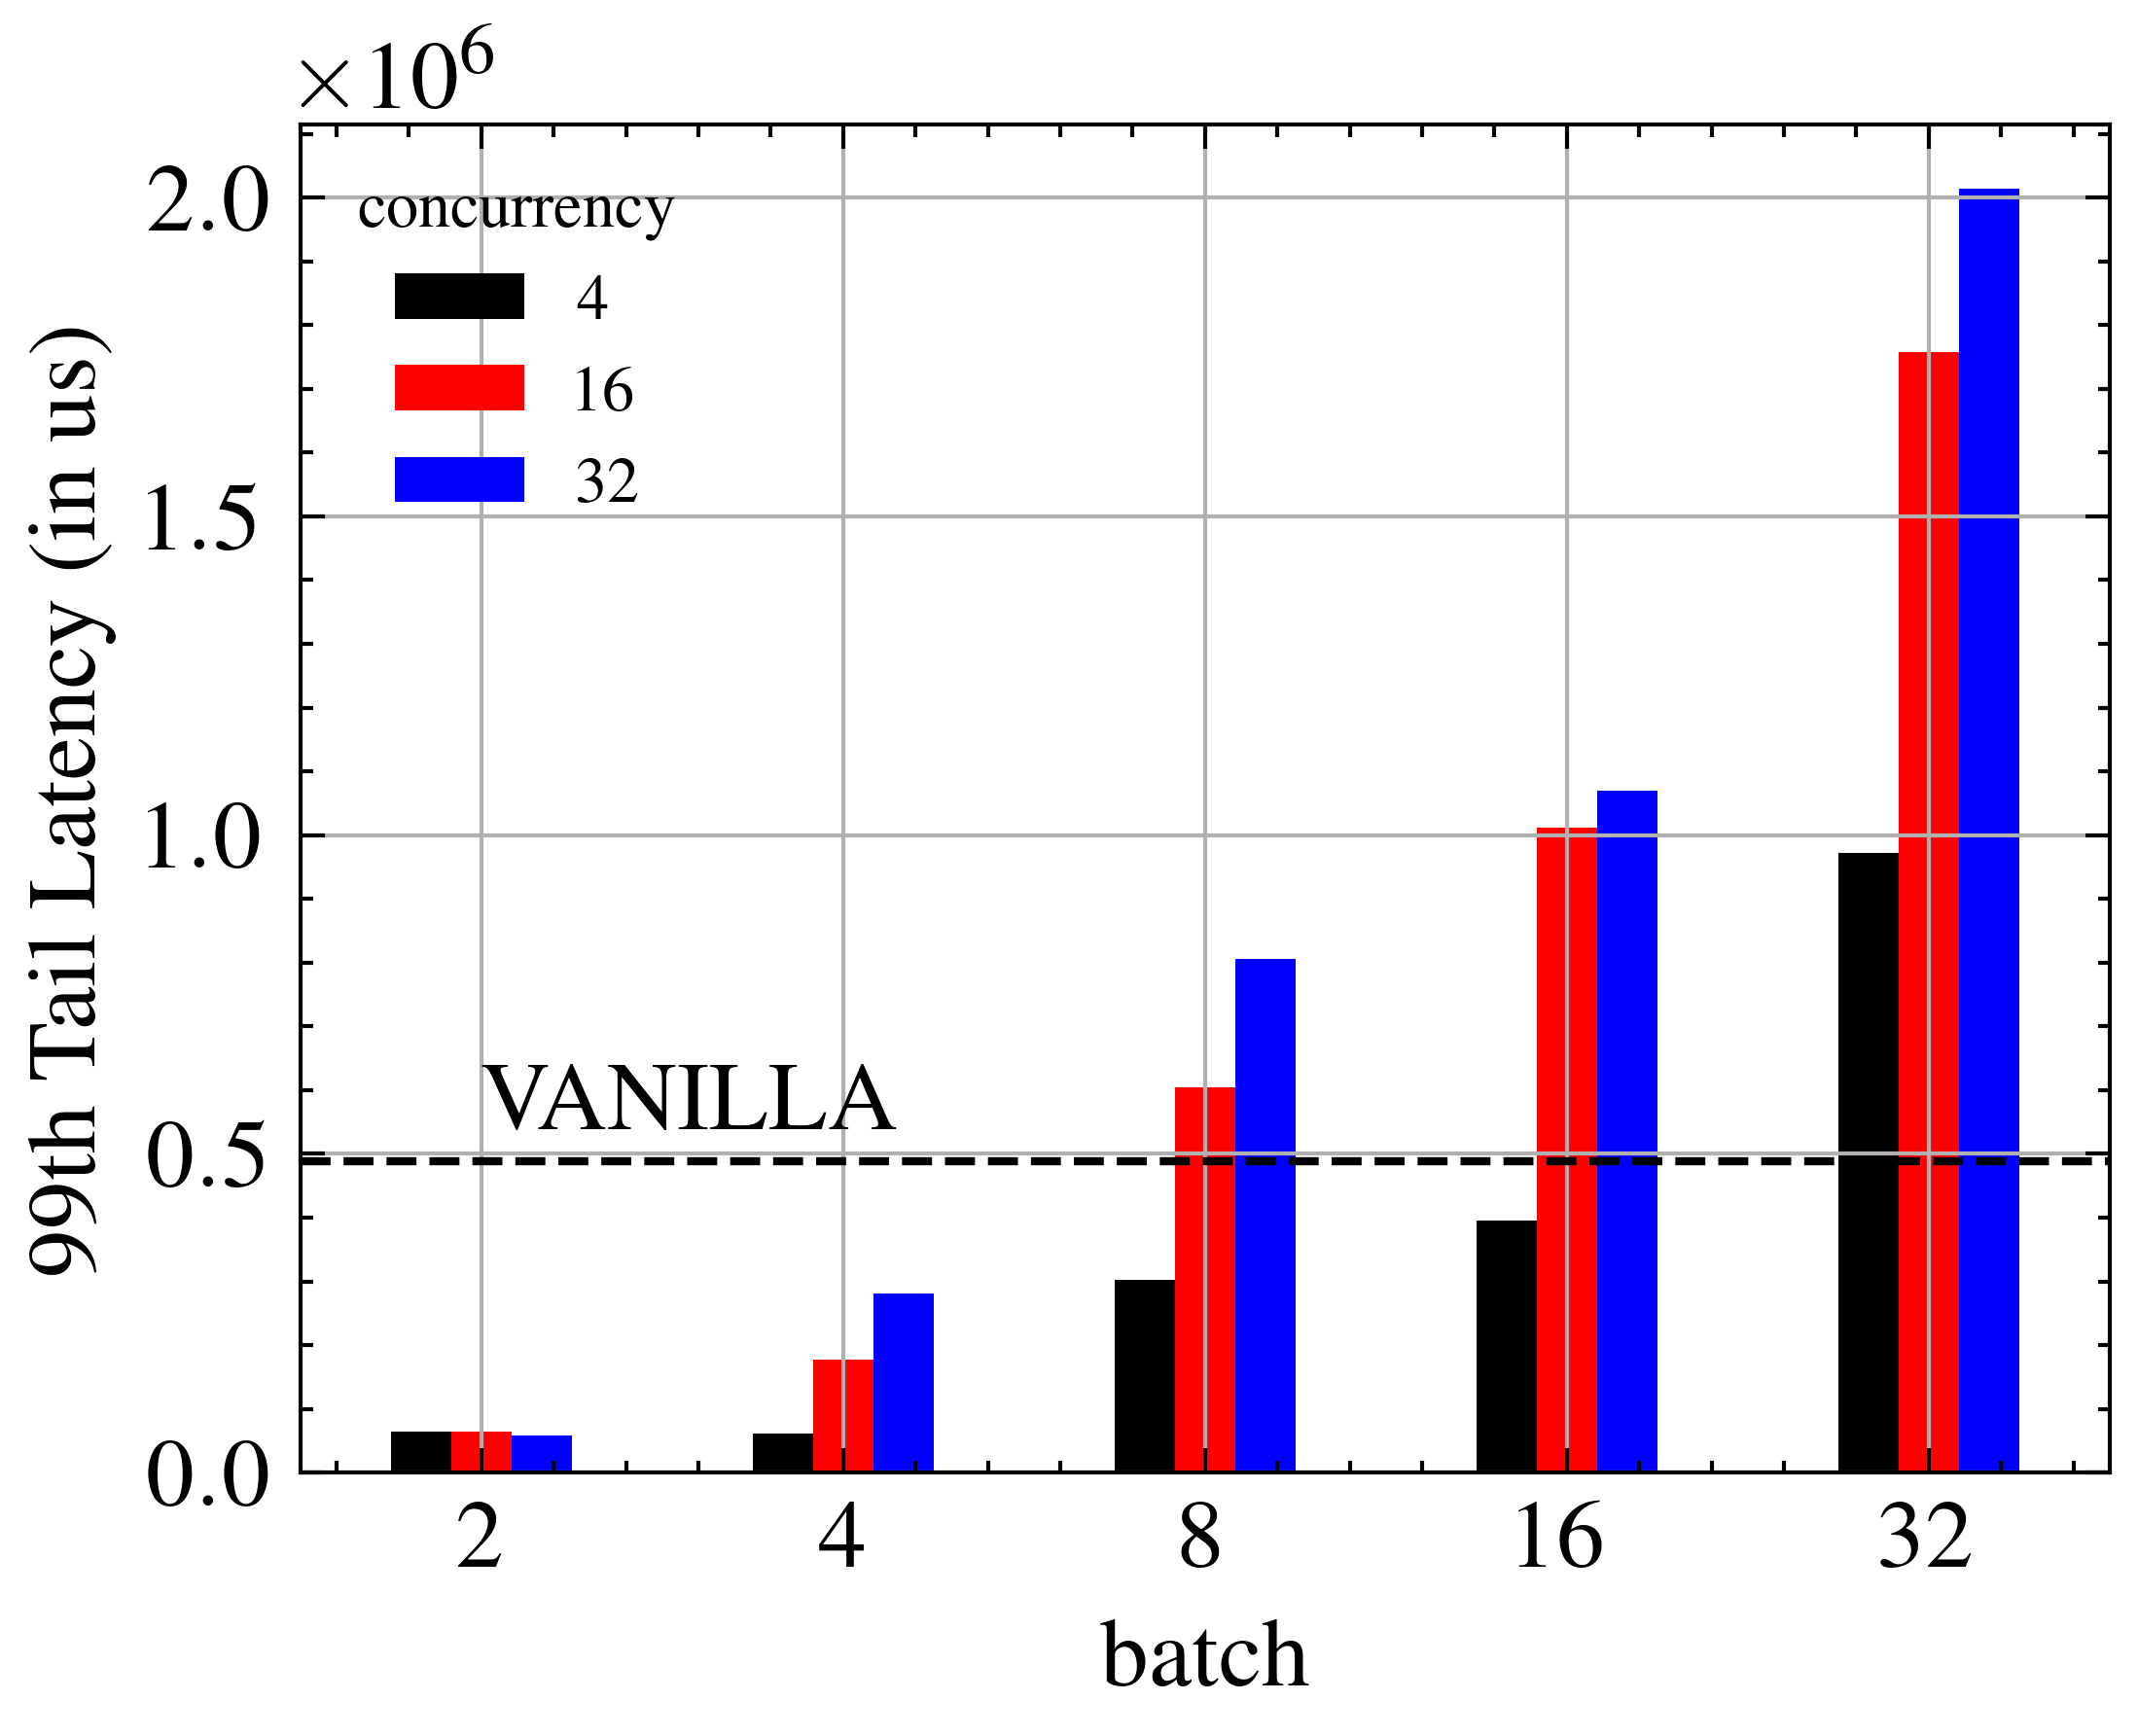

concurrency,4,16,32
batch,,,
2,63847.000,64170.381,57780.135
4,62023.400,177606.000,281617.977
8,302226.000,604341.000,806112.000
16,395183.000,1011075.124,1069229.132
32,972679.912,1757360.000,2013534.445


In [552]:
df_latency = pd.read_csv(f"../{res_dirs_[variant]}/summary/latency.csv").dropna().replace(0, np.nan)
plot_batch(df_latency, 'p99', '99th Tail Latency (in us)', 
           normal_value=out_vanilla['Latency'], 
           text_offset=0, text_spacing=50000)

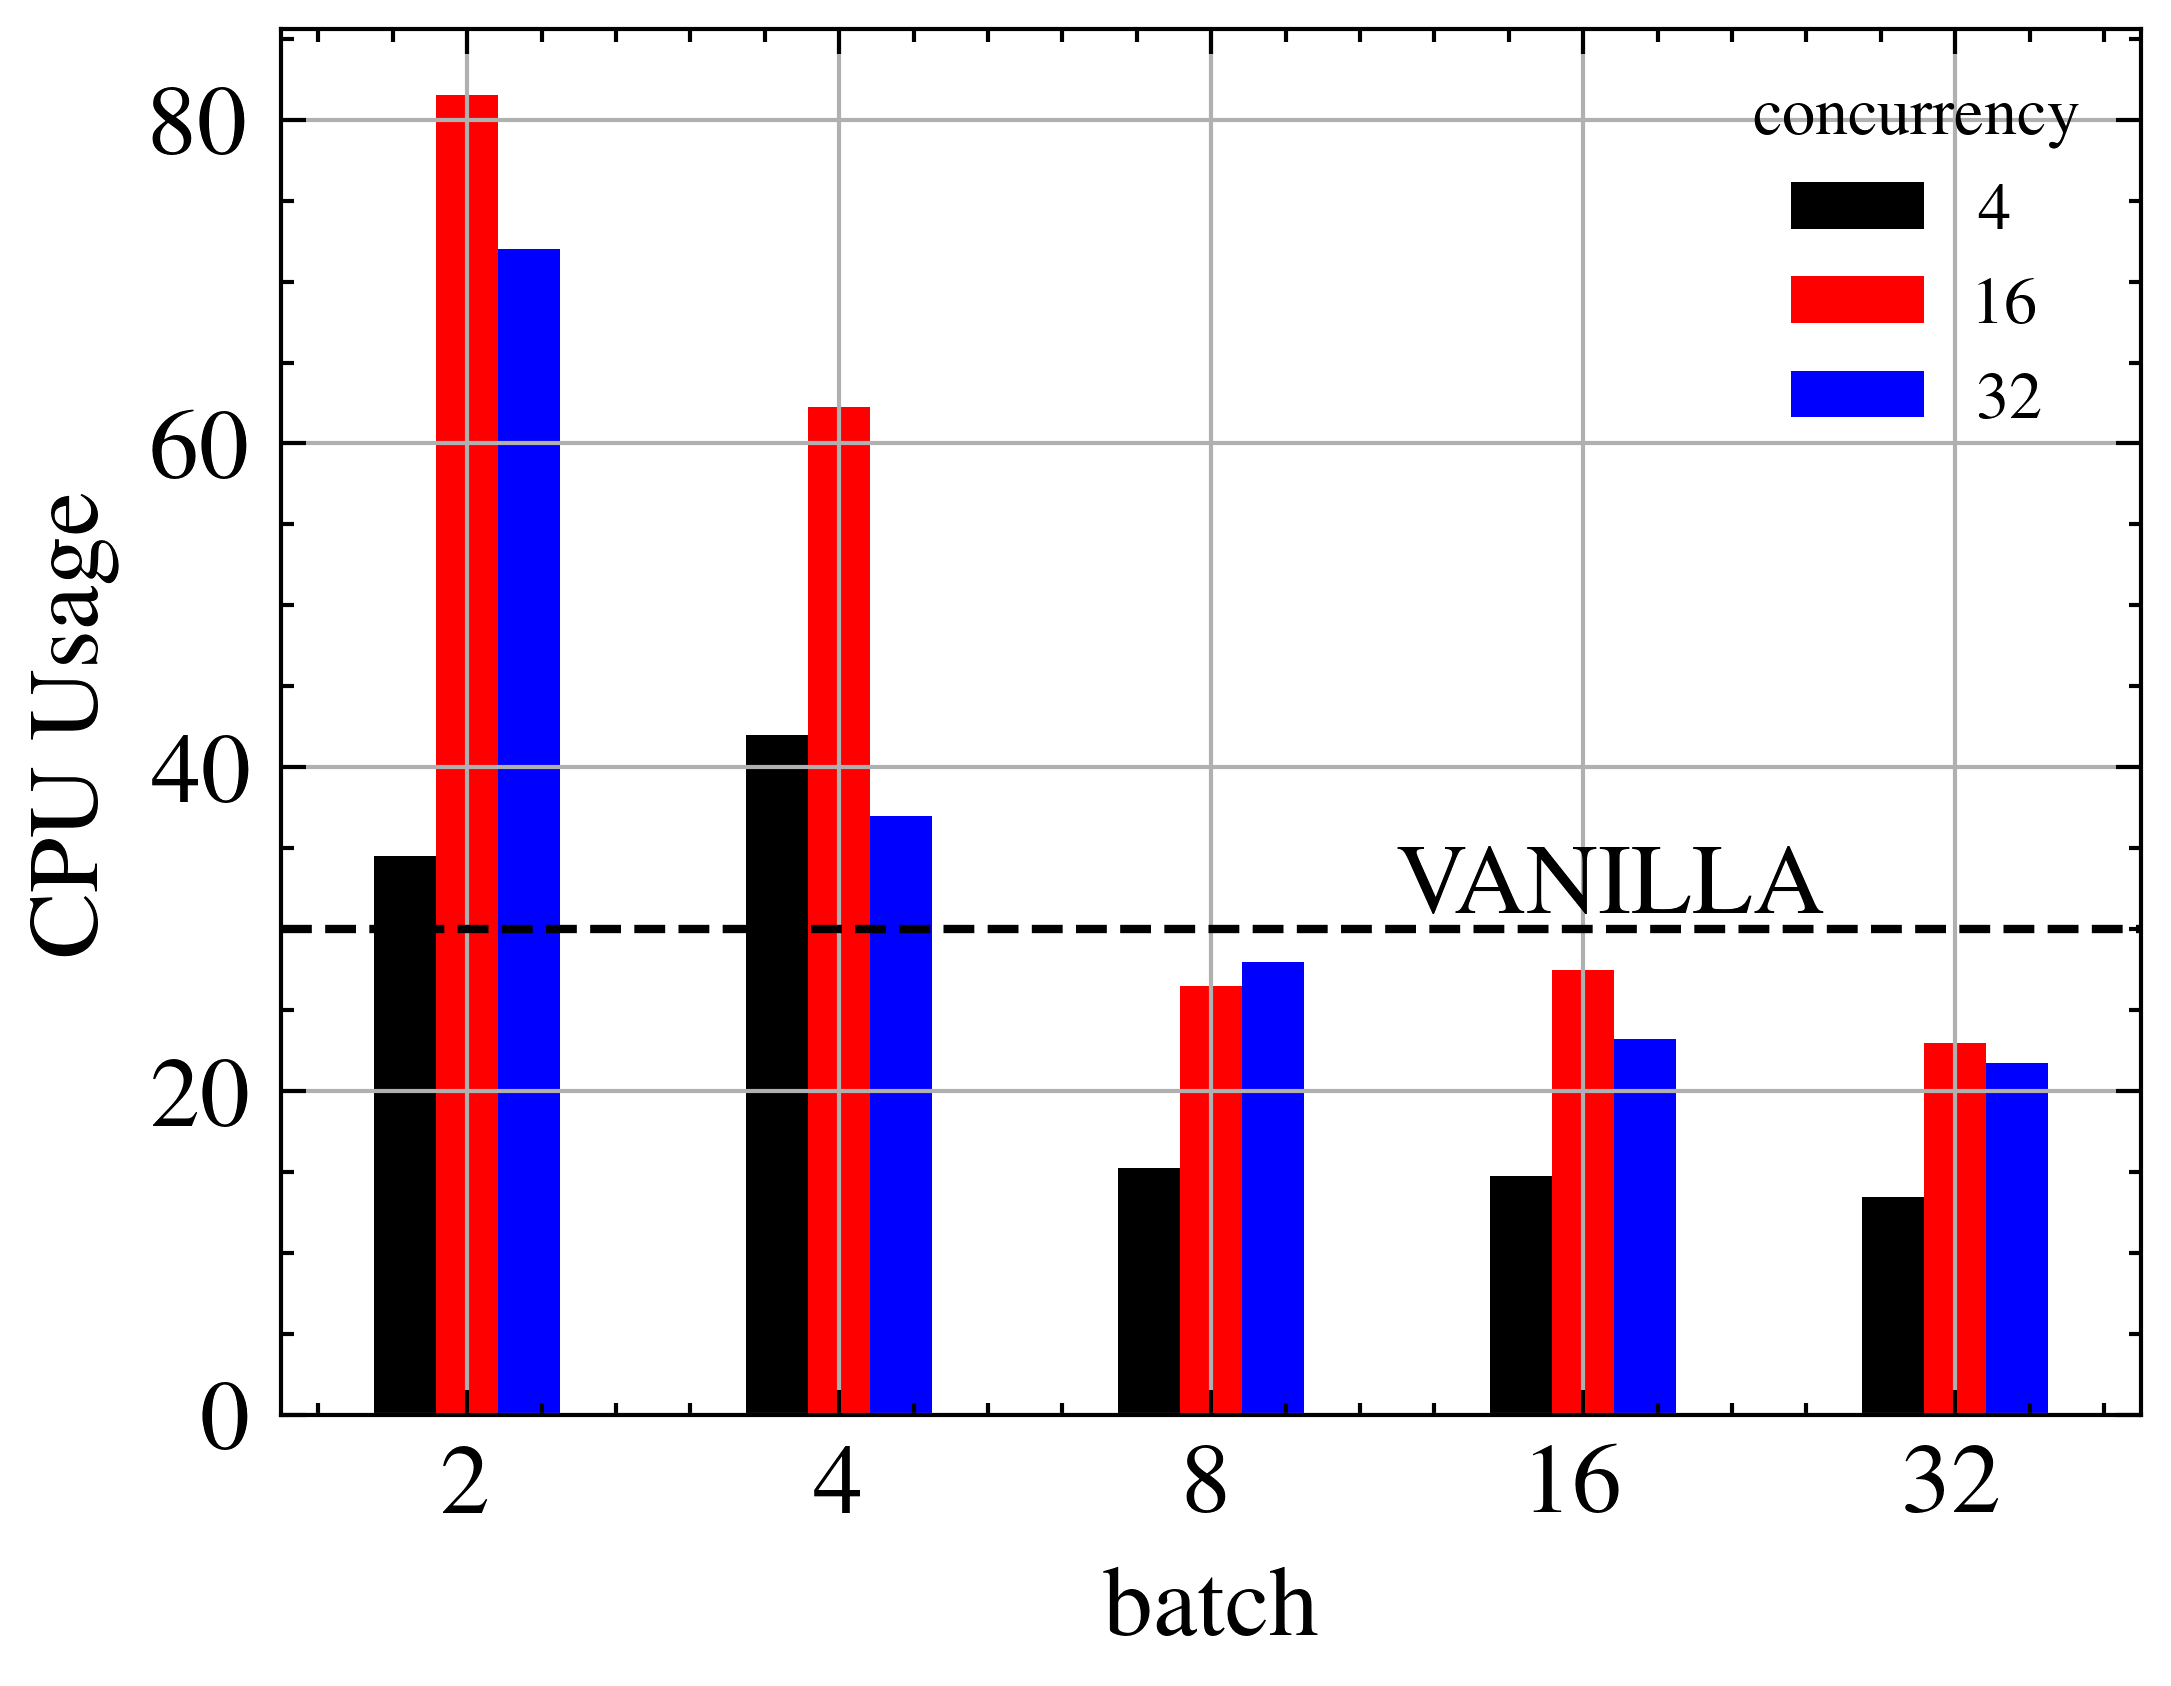

concurrency,4,16,32
batch,,,
2,34.50,81.50,72.00
4,42.00,62.25,37.00
8,15.25,26.50,28.00
16,14.75,27.50,23.25
32,13.50,23.00,21.75


In [555]:
dfs_cpu = import_pidstat(res_dirs_[variant], batched=True)
df_cpu = pd.concat(dfs_cpu.values(), axis=0).rename(columns={'client': 'clients'})
plot_batch(df_cpu, 'used', 'CPU Usage', normal_value=out_vanilla['cpu'], text_spacing=1)